# [IAPR 2019:][iapr2019] Lab 1 ‒  Image segmentation

**Author:** Jean-Baptiste PROST <br>
**Due date:** 04.04.2019

[iapr2019]: https://github.com/LTS5/iapr-2019

[Scikit-image](http://scikit-image.org/docs/stable/api/api.html) reference.

## Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os


data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'

if not os.path.isdir(data_base_path): #if the file has already been extracted
    
    tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')


    with tarfile.open(tar_path, mode='r:gz') as tar:
        tar.extractall(path=data_base_path)
        
else:
    print('Files already extracted')
    pass

Files already extracted


## Part 1: Brain segmentation

Your goal: compute the size of the brain (in pixels) in a 2D image of a human head taken by Magnetic Resonance Imaging (MRI).
* Try as many methods as you can, the more the better.
* At least region growing and contour detection.

### 1.1 Brain image visualization

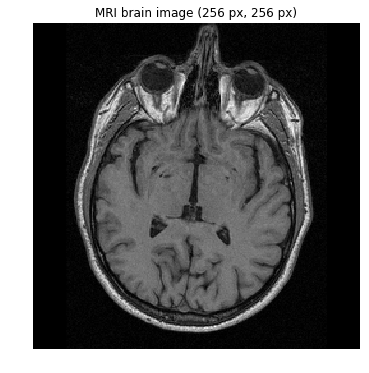

In [2]:
import skimage.io
import skimage.exposure
import skimage.morphology
from skimage import color
from skimage.measure import label, regionprops

import cv2
import matplotlib.patches as mpatches


import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
%matplotlib inline

# Load image
data_path = os.path.join(data_base_path, data_folder)
#load in grayscale
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'), as_gray=True,)
im_h, im_w = brain_im.shape

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

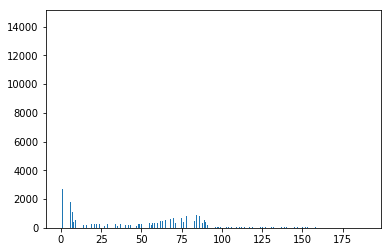

In [3]:
plt.hist(brain_im.flatten(), bins=int((im_h*im_w)/100))
plt.show()

### 1.2 Region growing
Add your implementation and discussion

,Value
Otsu,42
Yen,94
Isodata,42
Li,22.2702
Minimum,36
Mean,35.1625
Triangle,11


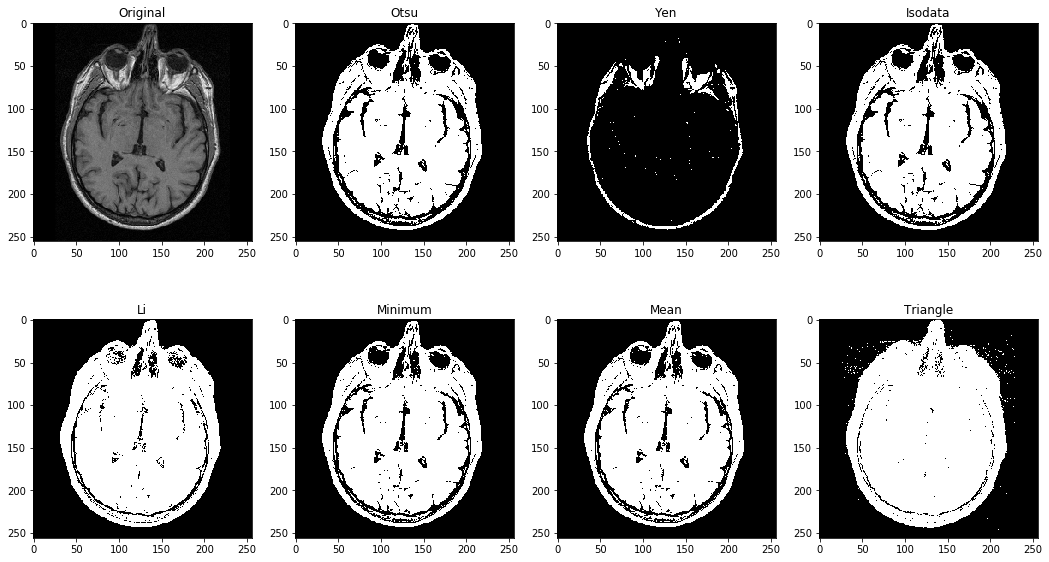

In [4]:
from skimage.filters import *

#Trying different threshold calculations methods
threshold_functions= [threshold_otsu, threshold_yen, threshold_isodata, threshold_li, threshold_minimum, threshold_mean, threshold_triangle]
threshold_labels=['Otsu', 'Yen','Isodata', 'Li', 'Minimum', 'Mean', 'Triangle']

thresholds=pd.DataFrame(index=threshold_labels, columns={'Value'})

plt.figure(figsize=(18,10))
plt.subplot(2,4,1)
plt.imshow(brain_im, cmap='gray')
plt.title('Original')

#plotting the results
for i, fct in enumerate(threshold_functions):
    threshold_tmp=fct(brain_im)
    thresholds.iloc[i,0]=threshold_tmp
    
    plt.subplot(2,4,i+2)
    plt.imshow(brain_im > threshold_tmp, cmap='gray')
    plt.title(threshold_labels[i])
    
display(thresholds)

'Otsu' seems to be a good solution

We will know build a clean, binary image. We start by filtering the binary image, then removing the points inside with a closing and then removing the white points with an opening

In [5]:
binary_image= brain_im<thresholds.loc['Otsu','Value']

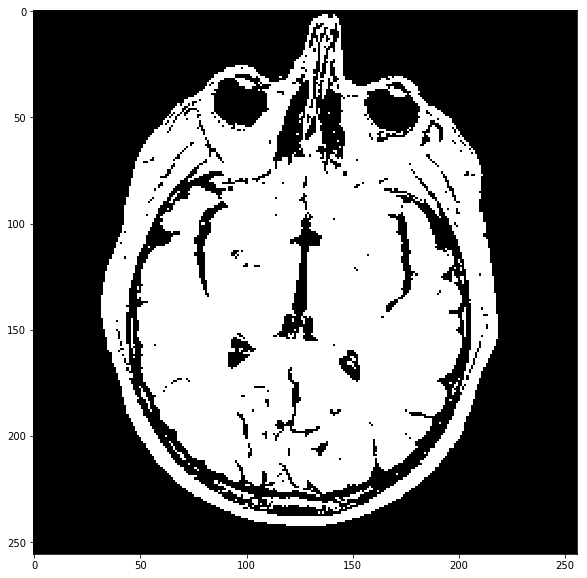

In [6]:
plt.figure(figsize=(18,10))
plt.imshow(~binary_image, cmap='gray')
plt.show()

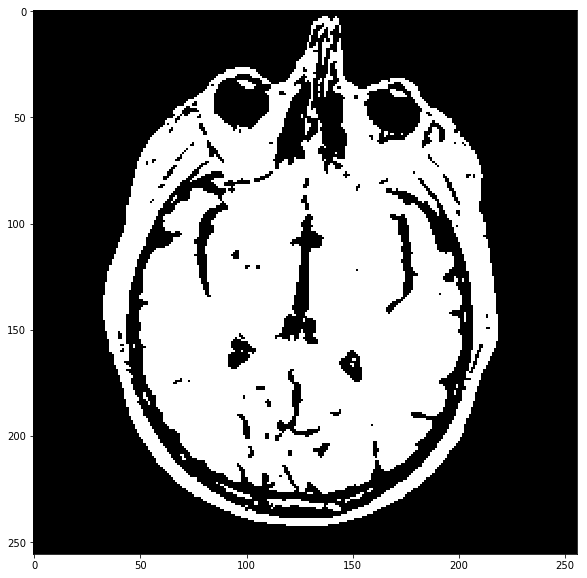

In [7]:
#Median filtering
kernel = np.ones((2,2))
filtered_img = skimage.filters.median(binary_image, selem=kernel)
plt.figure(figsize=(18,10))
filtered_img = ~filtered_img
plt.imshow(filtered_img, cmap='gray')
plt.show()

In [8]:
kernel = np.array([[0, 1, 1, 0],
                   [1, 1, 1, 1],
                   [0, 1, 1, 0],
                   [0, 1, 1, 0]],dtype=np.uint8)

#kernel = np.ones((2,2),np.uint8)

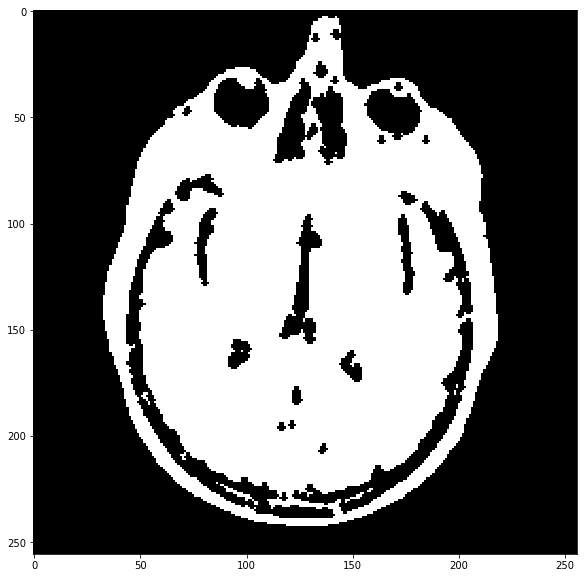

In [9]:
#Closing holes inside brain
closed_img = skimage.morphology.binary_closing(filtered_img, selem=kernel)
plt.figure(figsize=(18,10))
#opened_img = ~opened_img
plt.imshow(closed_img, cmap='gray')
plt.show()

In [10]:
kernel = np.array([[0, 0, 0, 0],
                   [1, 1, 1, 1],
                   [1, 1, 1, 1],
                   [0, 0, 0, 0]],dtype=np.uint8)

#kernel = np.ones((2,2),np.uint8)

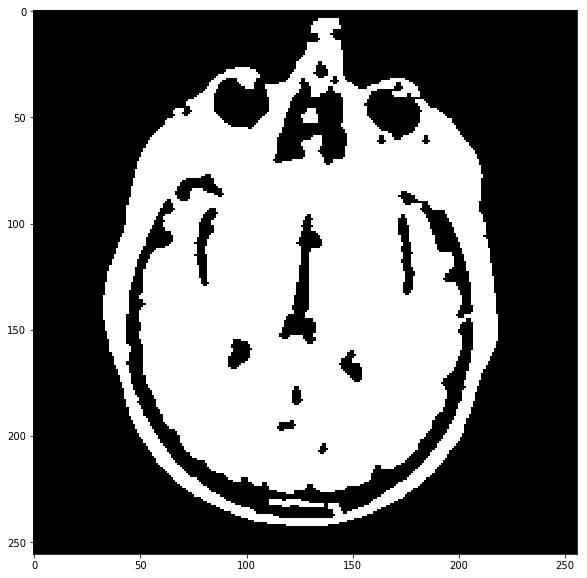

In [11]:
#removing lonely points with opening
closed_opened_img = skimage.morphology.binary_opening(closed_img,selem=kernel)
plt.figure(figsize=(18,10))
plt.imshow(closed_opened_img, cmap='gray')
plt.show()

3


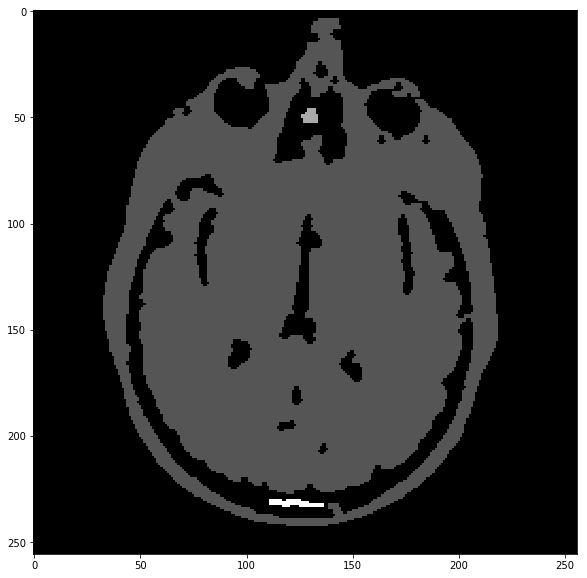

In [12]:
#Label images with region growing
labels,b = skimage.measure.label(closed_opened_img, return_num=True)
print(b)
plt.figure(figsize=(18,10))
plt.imshow(labels, cmap='gray')
plt.show()

### 1.2 Region growing
Add your implementation and discussion

In [13]:
#REgion growing using cv2 Floodfill
seed=(100,100)
mask = np.zeros((brain_im.shape[0]+2, brain_im.shape[1]+2), np.uint8)
a = cv2.floodFill(brain_im.copy(), mask, seedPoint=seed, newVal=(255,0,0), loDiff=(7), upDiff=(8))

#storing output image
grown_region_im = a[1]
print(a[0])

16379


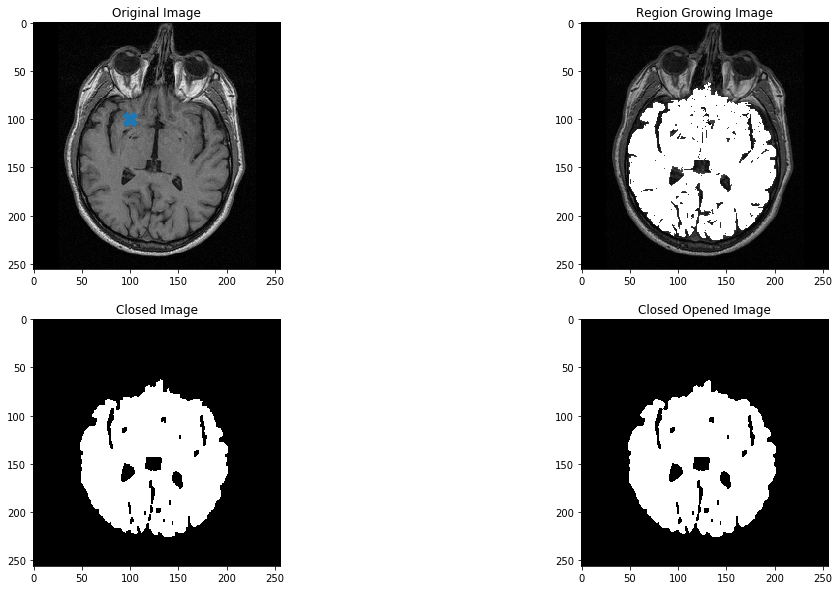

In [14]:
#Keeping image as binary output
binary_image= grown_region_im<255

#Closing holes inside brain
kernel_closing = np.array([[0, 1, 1, 0],
                   [0, 1, 1, 0],
                   [0, 1, 1, 0],
                   [0, 1, 1, 0]],dtype=np.uint8)

closed_img = skimage.morphology.binary_closing(~binary_image, selem=kernel_closing)

#opening
kernel_opening = np.array([[0, 1,  0],
                   [1, 1, 1],
                   [0, 1, 0]],dtype=np.uint8)
closed_opened_img = skimage.morphology.binary_opening(closed_img, selem=kernel_opening)

plt.figure(figsize=(18,10))

plt.subplot(2,2,1)
plt.imshow(brain_im, cmap='gray')
plt.scatter(seed[0], seed[1], marker='X', s=200)
plt.title('Original Image')

plt.subplot(2,2,2)
plt.imshow(grown_region_im, cmap='gray')
plt.title('Region Growing Image')

plt.subplot(2,2,3)
plt.imshow(closed_img, cmap='gray')
plt.title('Closed Image')

plt.subplot(2,2,4)
plt.imshow(closed_opened_img, cmap='gray')
plt.title('Closed Opened Image')

plt.show()

The final area is found by the final number of white pixels

In [15]:
closed_opened_img.sum()

16962

### 1.3 Contour detection
Add your implementation and discussion

### 1.4 Additional method(s)
Add your implementation and discussion

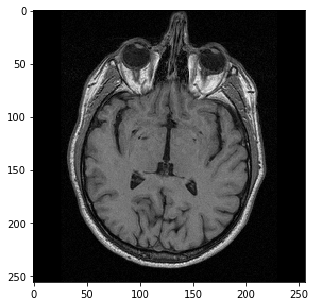

In [16]:
plt.figure(figsize=(9,5))
plt.imshow(brain_im, cmap='gray')
plt.show()

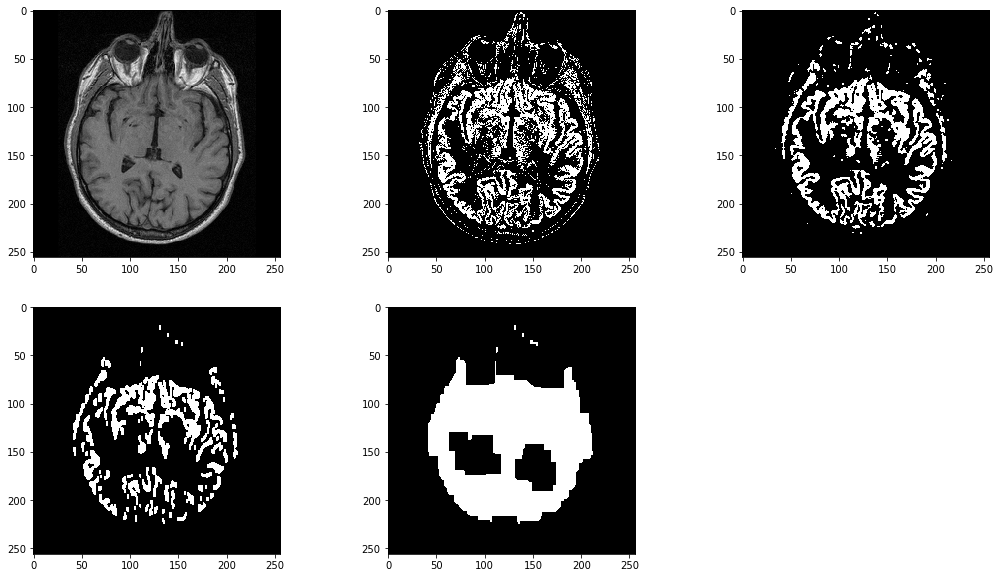

17011


In [17]:
binary_image = (brain_im < 79) & (brain_im > 60)
#binary_image = ~binary_image


kernel = np.ones((3,3))
filtered_img = skimage.filters.median(binary_image, selem=kernel)

kernel_opening = np.array([[0, 1, 1, 0],
                   [0, 1, 1, 0],
                   [0, 1, 1, 0],
                   [0, 1, 1, 0]],dtype=np.uint8)

kernel_closing = np.array([[0,0,1,1,1,0,0],
                         [0,0,1,1,1,0,0],
                         [1,1,1,1,1,1,1],
                         [1,1,1,1,1,1,1],
                         [1,1,1,1,1,1,1],
                         [0,0,1,1,1,0,0],
                         [0,0,1,1,1,0,0]], dtype=np.uint8)
opened_img = skimage.morphology.binary_opening(filtered_img, selem=kernel_opening)

kernel_closing = np.ones((20,20))
closed_img = skimage.morphology.binary_closing(opened_img, selem=kernel_closing)



plt.figure(figsize=(18,10))
plt.subplot(2,3,1)
plt.imshow(brain_im, cmap='gray')

plt.subplot(2,3,2)
plt.imshow(binary_image, cmap='gray')

plt.subplot(2,3,3)
plt.imshow(filtered_img, cmap='gray')

plt.subplot(2,3,4)
plt.imshow(opened_img, cmap='gray')

plt.subplot(2,3,5)
plt.imshow(closed_img, cmap='gray')

plt.show()

print(closed_img.sum())

## Part 2: Save the bees !

Varroa mites are recognized as the biggest pest to honey bees worldwide, and are believed to be the single largest contributing factor in the modern-day decline of honey bees due to their ability to transmit diseases, resulting in death or severe deformity of the pupae. 

Detecting and quantifying the presence of Verroa in a beehive is therefore crucial to treat the infection appropriately and as early as possible, and image analysis appears very useful in this problem.

![Varroa Mite](https://lts5www.epfl.ch/wp-content/uploads/2018/07/varroa-2.jpg)



### 2.1 Introduction to Project

You will find hereafter a set of 4 images taken under real conditions. In this task you will be ask to:
1. Count the number of Varroa on each picture
2. Determine the Intersection over Union of the detected patterns w.r.t. the ground truth
3. Estimate the Precision, Recall and F1-score at two different IoU thresholds $T = {0.5 \text{, and } 0.9}$


**Note** 

Try to have the same routine(s) running on the four images, and giving (approximatively) the same results. The routine(s) that you will write for this part will be useful for the final project as well, so pay special attention to it.

#### Vocabulary


* **IoU**: Let $A$ be the ground truth area and $B$ the predicted one. the intersection over union (IoU) is given as:
$$IoU(A,B) = \frac{A \cap B}{A \cup B} = \frac{\text{Area of Overlap}}{\text{Area of Union}}$$
Let $T$ be a scalar in the interval $[0, 1]$, then $B$ will be considered as a true positive (TP) if and only if $IoU(A,B) \ge T$. As a results, we can evaluate the performance of our detection with different values of $T$. The larger $T$ is, the more constraining is our condition.


* **Precision**: The precision is given as:
$$precision = \frac{tp}{tp + fp}$$
where $tp$ is the number of true positives and $fp$ the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.


* **Recall**: The recall is given as:
$$precision = \frac{tp}{tp + fn}$$
where $tp$ is the number of true positives and $fn$ the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.


* **F1-score**: The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:
$$F1 = \frac{2 \cdot precision \cdot recall}{precision + recall}$$


**FAQ**

Q: What to do if I have multiple ground truth $A_i$ and candidates $B_j$ and want to find the best set $(i,j)$ such that $(i, j) = \arg\max_{i,j} IoU(A_i, B_j)$ ? 

A: Here, we recommend to use a brute force approach. It corresponds to compute $IoU(A, B)$ for every possible pairs (i,j) and keep the pair with the highest $IoU$. Note that a candidate $B_j$ can **only** be matched to **one** ground truth area $A_i$.

Here, we visualize the 4 images for our patern detection

In [18]:
# Load images
im_names = ['varroa-01', 'varroa-02', 'varroa-03', 'varroa-04']
filenames = [os.path.join(data_path, name) + '.jpg' for name in im_names]
ic = skimage.io.imread_collection(filenames)
print('Number of images: ', len(ic))

Number of images:  4


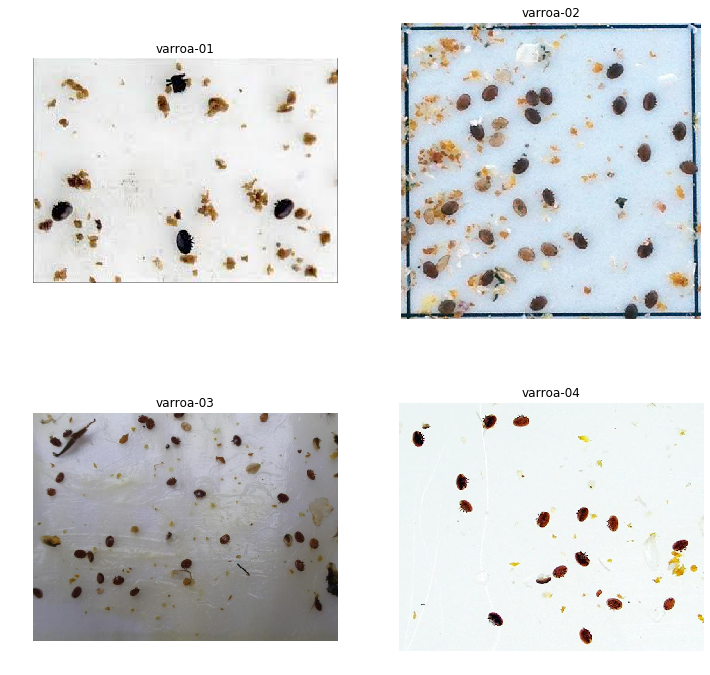

In [19]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), ic, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

We can as well add the groud truth label that are stored in the corresponding XML files. Each xml file stores the position of the varroa on the image as :

```xml
<annotation>
	<object>
		<name>Varroa</name>
		<difficult>0</difficult>
		<bndbox>
			<xmin>14</xmin>
			<ymin>117</ymin>
			<xmax>33</xmax>
			<ymax>137</ymax>
		</bndbox>
	</object>
	<object>
		...
	</object>
	...
</annotation>
```
The block `object` defines the attributes of the varroa. `name` is the definition of the object class (always varroa). `bndbox` is the definition of the bounding box. To simplify your task, we implemented a function named `parse_file` that returns an array with the bounding box of the varroa expressed as `(x, y, width, heigth)` which corresponds to `(xmin, ymin, xmax-xmin, ymax-ymin)`

In [20]:
import xml.etree.ElementTree as ET

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [21]:
annotations_xmls = [parse_file(os.path.join(data_path, name) + '.xml') for name in im_names]

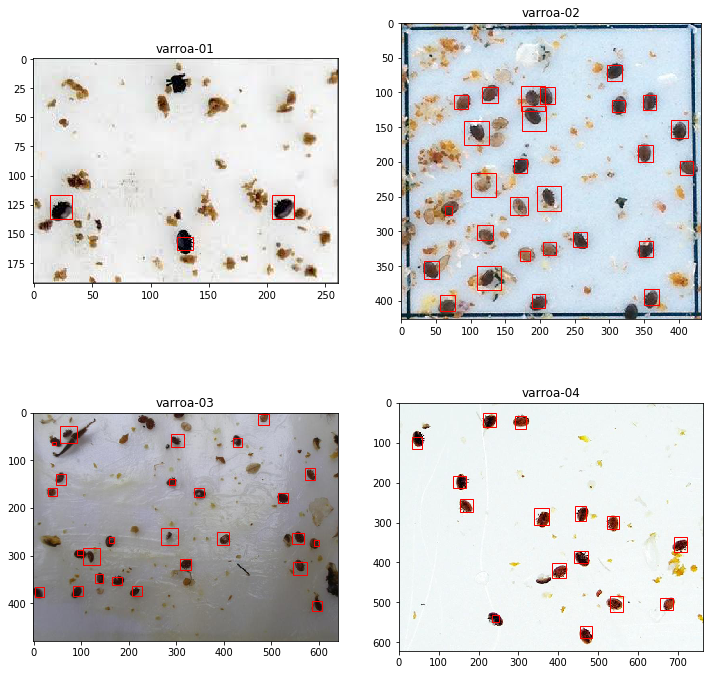

In [22]:
# Plot images
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for ax, im, nm, annotations in zip(axes.ravel(), ic, im_names, annotations_xmls):
    # Iterate over annotations
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    
    ax.imshow(im)
    #ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Count the number of Varroa on each picture

Add your implementation and discussion

Hint: `skimage.measure.label` might be useful to label the thresholded image

In [23]:
def image_cleaning(image, threshold = 0.1, kernel_filtering = np.ones((4,4)), kernel_opening = np.ones((3,3)), plot=False, annot=False):
    '''
    This functions applyes a threshold on a gray scale image, filters this obtained image and then opens it.
    It returns the filtered-opened image and plots the evolution if plot == 1
    
    args:
    image [np.array] : a grayscale image 
    threshold [float] : a threshold for selecting dark shapes
    kernel_filtering [np.array] : an array used as kernel for median filtering
    kernel_opening [np.array] : used as kernel for morphologicyl opening
    plot [bool] : Bool to decide wether to plot or not
    annot [xlms] : annotations for the boxes 
    
    output:
    im [np.array] : the image after threshold, filtering, opening and closing
    '''
    
    images_list = []
    titles_list = []
    
    #images_list.append(image)
    #titles_list.append('Original Image')
    
    grayscale_img = color.rgb2gray(image)
    images_list.append(grayscale_img)
    titles_list.append('Grayscale Image')

    
    threshold_img = grayscale_img < threshold
    images_list.append(threshold_img)
    titles_list.append('Thresholded Image ' + str(threshold))

    filtered_img = skimage.filters.median(threshold_img, selem=kernel_filtering)
    images_list.append(filtered_img)
    titles_list.append('Median-Filtered Image')
    
    opened_img = skimage.morphology.binary_opening(filtered_img, selem=kernel_opening)
    opened_img = skimage.morphology.binary_opening(filtered_img, selem=kernel_opening)
    images_list.append(opened_img)
    titles_list.append('Filtered-Opened Image')

    dilated_img = skimage.morphology.dilation(opened_img, selem=np.ones((4,4)))
    images_list.append(dilated_img)
    titles_list.append('Filtered-Opened-Dilated Image')
    

    if plot == True:
        
        fig, axes = plt.subplots(1, 5, figsize=(18, 18))
        
        i=0
        for ax in axes.ravel():
            ax.imshow(images_list[i], cmap='gray')
            ax.set_title(titles_list[i])
            if annot != False:
                for anno in annotations:
                    rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                    linewidth=1,edgecolor='r',facecolor='none')
                    ax.add_patch(rect)
            i=i+1
        plt.show()
    return opened_img


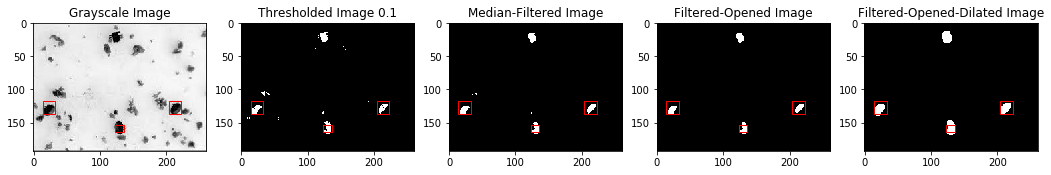

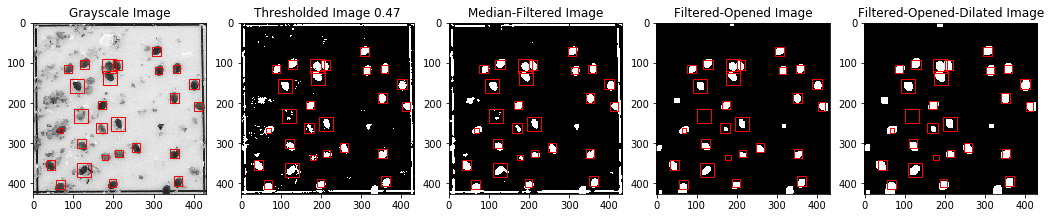

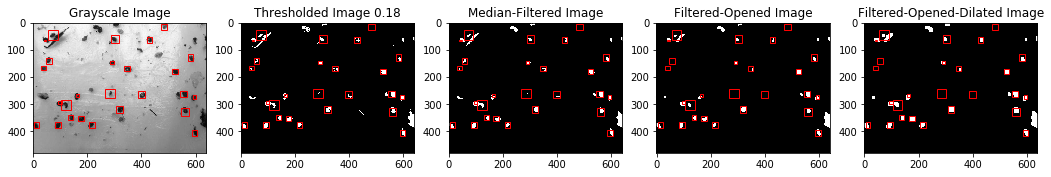

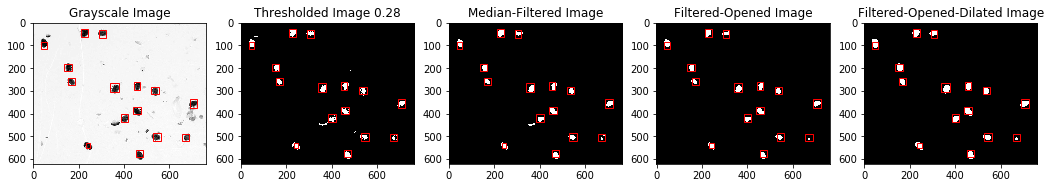

In [24]:
thresholds = [0.1, 0.47, 0.18, 0.28]

filtering_ks = [np.ones((4,4)),\
               np.ones((6,6)),\
               np.array( [[0,0,1,1,1,1,0,0],
                         [0,0,1,1,1,1,0,0],
                         [1,1,1,1,1,1,1,1],
                         [1,1,1,1,1,1,1,1],
                         [1,1,1,1,1,1,1,1],
                         [1,1,1,1,1,1,1,1],
                         [0,0,1,1,1,1,0,0],
                         [0,0,1,1,1,1,0,0]], dtype=np.uint8),\
              np.array( [[0,0,1,1,1,1,0,0],
                         [0,0,1,1,1,1,0,0],
                         [1,1,1,1,1,1,1,1],
                         [1,1,1,1,1,1,1,1],
                         [1,1,1,1,1,1,1,1],
                         [1,1,1,1,1,1,1,1],
                         [0,0,1,1,1,1,0,0],
                         [0,0,1,1,1,1,0,0]], dtype=np.uint8)]

opening_ks = [np.ones((3,3)),\
                np.ones((8,8)),\
              np.ones((6,6)),\
              np.array( [[0,0,1,1,1,1,0,0],
                         [0,0,1,1,1,1,0,0],
                         [1,1,1,1,1,1,1,1],
                         [1,1,1,1,1,1,1,1],
                         [1,1,1,1,1,1,1,1],
                         [1,1,1,1,1,1,1,1],
                         [0,0,1,1,1,1,0,0],
                         [0,0,1,1,1,1,0,0]], dtype=np.uint8)]

closing_ks = [np.ones((3,3)),\
               np.ones((5,5)),\
              np.ones((5,5)),\
              np.ones((5,5))]
images_bee = []
for im, thre, filt, op, annotations in zip(ic, thresholds, filtering_ks, opening_ks, annotations_xmls):
    images_bee.append(image_cleaning(im, thre, kernel_filtering=filt, kernel_opening=op, plot=True, annot=annotations))
    

#### We know have clearly separated shapes, we need to count the number of shapes we have

In [183]:
def plotting_images_w_boxes(list_of_images, list_of_boxes, colors, names, legends):
    '''
    Plots multiple boxes type of a given color for a given color
    
    args:
    list_of_images [np.array] : images
    list_of_boxes [[[regionprops or dict]]] : boxes to plot
    color [str] : list of string (same len as list_of_boxes)
    names [str] : list of string with names for images (same len as list_of_images)
    legend [str] : list of legends for boxes
    '''
    fig, axes = plt.subplots(int(len(list_of_images)/2), int(len(list_of_images)/2), figsize=(18, 12))
    for image, ax, nm, i in zip(list_of_images, axes.ravel(), names, range(len(list_of_images))):
        ax.imshow(image, cmap = 'gray')
        ax.set_title(nm) 
        for type_of_boxes, c in zip(list_of_boxes, colors):
            for box in type_of_boxes[i]:
                if isinstance(box, skimage.measure._regionprops._RegionProperties):
                    minr, minc, maxr, maxc = box.bbox
                    rect = patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor=c, linewidth=2)
                    ax.add_patch(rect)
                elif isinstance(box, dict):
                    rect = patches.Rectangle((box['bbox'][0], box['bbox'][1]), box['bbox'][2], box['bbox'][3],
                    linewidth=1,edgecolor=c,facecolor='none')
                    ax.add_patch(rect)

    for l, c, j in zip(legends, colors, range(len(legends))):    
        plt.text(0, -j*40, l,
         {'color': c, 'fontsize': 10, 'ha': 'left', 'va': 'center',
          'bbox': dict(boxstyle="round", fc="w", ec="k", pad=0.2)})

-------------------------------------------------------
Counted: 4
Actual: 3
Accuracy: 0.75
-------------------------------------------------------
Counted: 30
Actual: 27
Accuracy: 0.9
-------------------------------------------------------
Counted: 29
Actual: 26
Accuracy: 0.9
-------------------------------------------------------
Counted: 15
Actual: 15
Accuracy: 1.0


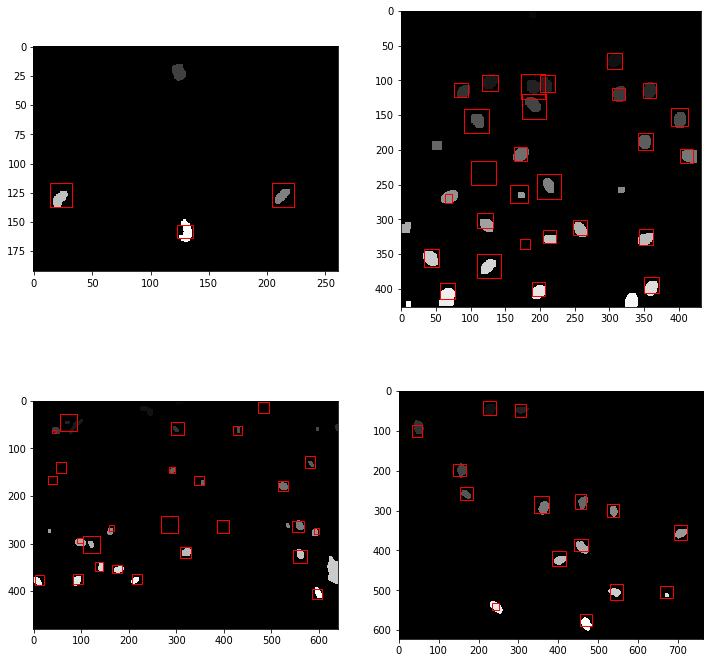

In [184]:
labels_img = []

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

for larvea_im, annotations, ax in zip(images_bee, annotations_xmls, axes.ravel()):
    labeled,b = skimage.measure.label(larvea_im, return_num=True)
    labels_img.append([labeled,b])
    
    i=0
    for anno in annotations:
        rect = patches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        i=i+1
    print("-------------------------------------------------------") 
    print('Counted:', b)
    print('Actual:', i)
    print('Accuracy:', np.round(i/b,2))
    
    ax.imshow(labeled, cmap='gray')
    
plt.show()

### 2.3 IoU of the detected pattern w.r.t. the ground truth

Add your implementation and discussion

Hint: `skimage.measure.regionprops` implements a large variety of descriptors

In [185]:
def create_bounding_boxes(image):
    '''
    Returns bounding boxes from labeled image
    '''
    regions = []
    for region in regionprops(image):
        # take regions with large enough areas
        if region.area >= 70:
            # draw rectangle around segmented coins
            regions.append(region)  
    return regions   

In [186]:
region_img = []
for image in labels_img:
    region_img.append(create_bounding_boxes(image[0].copy()))

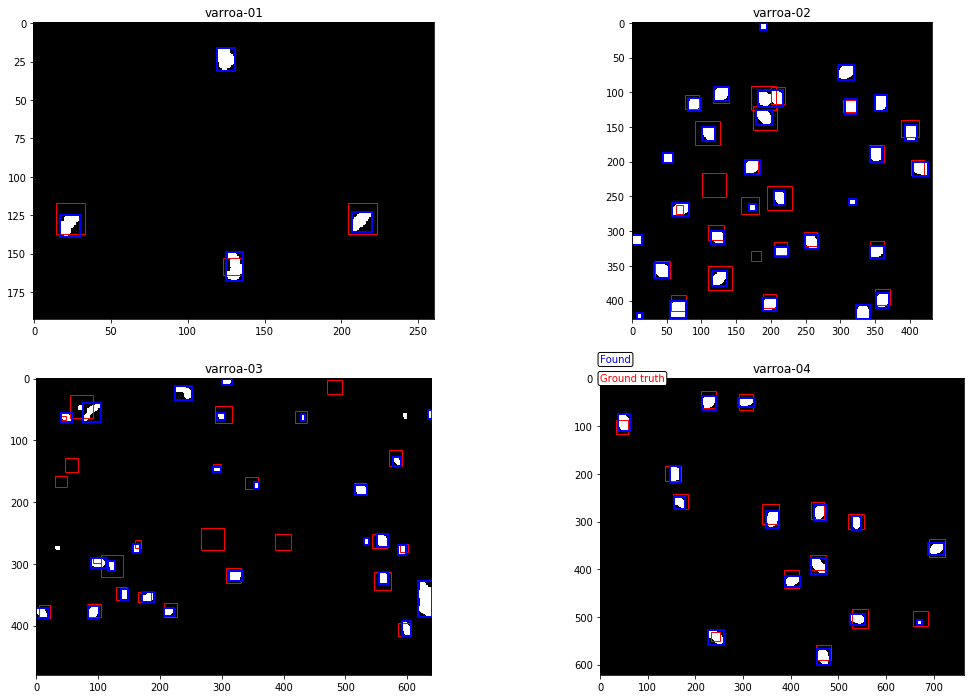

In [187]:
boxes_to_plot = [annotations_xmls, region_img]

plotting_images_w_boxes(images_bee, boxes_to_plot,['r','b'], im_names, ['Ground truth', 'Found'])

In [188]:
def bb_intersection_over_union(boxA, boxB):
    '''
    Given two bounding boxex, calculates IoU
    
    args:
    boxA (int,int,int,int) : (ymin, xmin, ymax, xmax)
    boxB (int,int,int,int) : (ymin, xmin, ymax, xmax)
    
    output:
    IoU (float) : IoU of boxA and boxB
    
    credits to Adrian Rosebrock : https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
    '''
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
 
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
        
    if interArea > 0:
        # compute the area of both the prediction and ground-truth
        # rectangles
        boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
        boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

        # compute the intersection over union by taking the intersection
        # area and dividing it by the sum of prediction + ground-truth
        # areas - the interesection area
        iou = interArea / float(boxAArea + boxBArea - interArea)

        # return the intersection over union value
    else :
        iou = 0
        
    return iou

In [200]:
def IoU_bbox(detected, ground_truth, threshold, images):
    '''
    
    
    '''

    
    region_kept = []
    
    
    #for each images, extract ax, list of detected boxes and true boxes
    for image_detected, image_true, ax, im in zip(detected, ground_truth, axes.ravel(), images):
        
        #list to store boxes with iou > threshold by image
        region_kept_by_image = []
        
        #for each detected box, go over all true boxes
        for detected_box in image_detected:
            for region in image_true:   
                
                #modyfying bbox of true to satisfy bbox format or regionprop
                bbox_modified = (region['bbox'][1], region['bbox'][0], \
                                region['bbox'][1] + region['bbox'][3], \
                                region['bbox'][0] + region['bbox'][2])
                #calculates IoU
                iou = bb_intersection_over_union(detected_box.bbox, bbox_modified)
                
                #if IoU satisfactory
                if iou > threshold:
                    #keep box
                    region_kept_by_image.append(detected_box)
                   
        region_kept.append(region_kept_by_image)

    return region_kept

----------------------------------------------  Threshold: 0.2 ----------------------------------------------


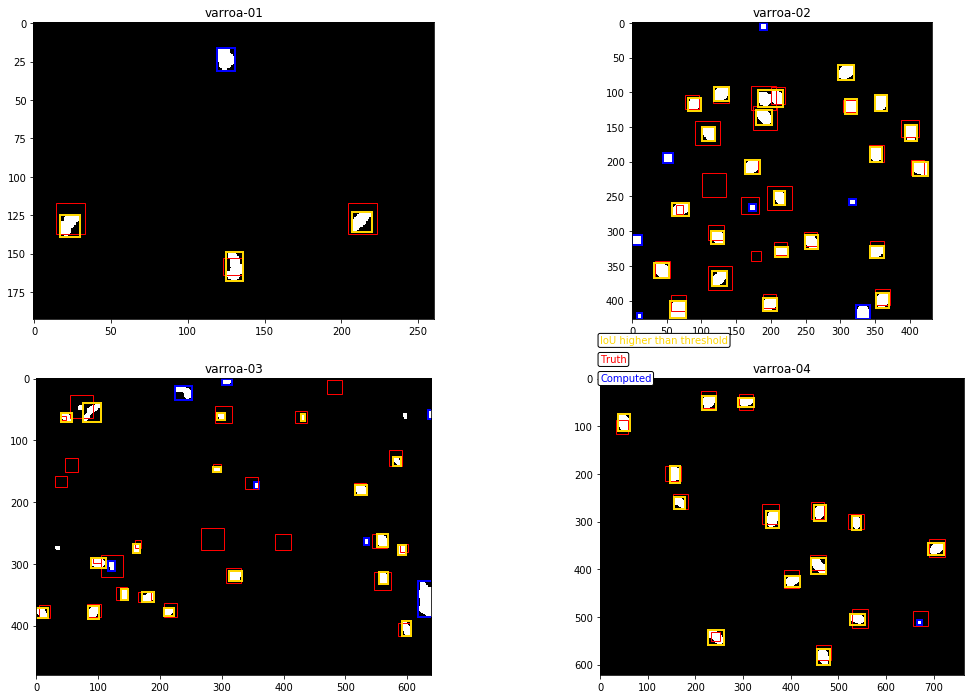

In [206]:
iou_threshold = 0.2

bbox_higher_than_threshold = IoU_bbox(region_img, annotations_xmls, iou_threshold, images_bee)
colors = ['b', 'r', 'gold']
legends = ['Computed', 'Truth', 'IoU higher than threshold']
boxes_to_plot = [region_img, annotations_xmls, bbox_higher_than_threshold]
plotting_images_w_boxes(images_bee, boxes_to_plot, colors,im_names, legends)

print('----------------------------------------------  Threshold:', iou_threshold, \
      '----------------------------------------------')


----------------------------------------------  Threshold: 0.5 ----------------------------------------------


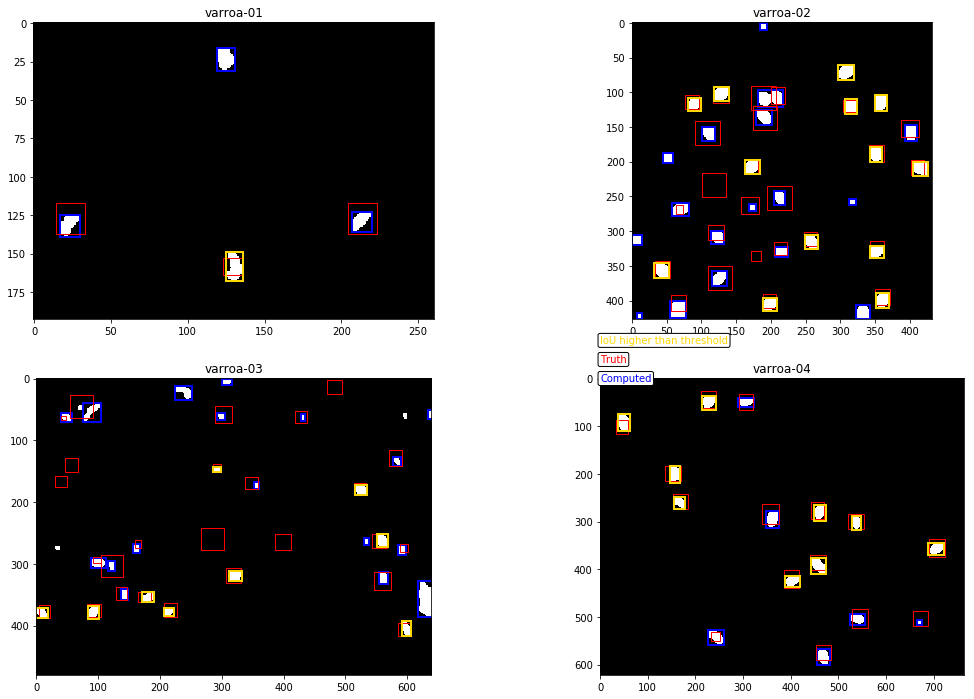

In [207]:
iou_threshold = 0.5

bbox_higher_than_threshold = IoU_bbox(region_img, annotations_xmls, iou_threshold, images_bee)
boxes_to_plot = [region_img, annotations_xmls, bbox_higher_than_threshold]
plotting_images_w_boxes(images_bee, boxes_to_plot, colors,im_names, legends)

print('----------------------------------------------  Threshold:', iou_threshold, \
      '----------------------------------------------')


### 2.4 Precision, Recall and F1-score at two different IoU thresholds

Add your implementation and discussion